# Diabetes Prediction

Link to the Dataset:
[Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

#About Dataset:
##`Context`
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

##`Content`
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [44]:
import pandas as pd
import numpy as np

In [14]:
# set seed for reproducibility
SEED = 20
np.random.seed(SEED)

In [15]:
# Loading Data
df = pd.read_csv('../diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Exploratory Data Analysis

In [16]:
# checking null values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [18]:
# Check for zero values in all columns
zero_values = (df == 0).sum()

# Display the columns with zero values
print("Columns with zero values:")
print(zero_values[zero_values > 0])


Columns with zero values:
Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64


We have many zero values will definetely effect the model accuracy. We need to convert them with `nan` values.

Function to replace zero values with `nan`

In [19]:
def replace_zero(df):
    df_nan=df.copy(deep=True)
    cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
    df_nan[cols] = df_nan[cols].replace({0:np.nan})
    return df_nan
df_nan=replace_zero(df)

In [20]:
def find_median(frame,var):
    temp = frame[frame[var].notnull()]
    temp = frame[[var,'Outcome']].groupby('Outcome')[[var]].median().reset_index()
    return temp

In [21]:
# function to replace null values
def replace_null(frame,var):
    median_df=find_median(frame,var)
    var_0=median_df[var].iloc[0]
    var_1=median_df[var].iloc[1]
    frame.loc[(frame['Outcome'] == 0) & (frame[var].isnull()), var] = var_0
    frame.loc[(frame['Outcome'] == 1) & (frame[var].isnull()), var] = var_1
    return frame[var].isnull().sum()

In [22]:
print(str(replace_null(df_nan,'Glucose'))+ ' Nulls for Glucose')
print(str(replace_null(df_nan,'SkinThickness'))+ ' Nulls for SkinThickness')
print(str(replace_null(df_nan,'Insulin'))+ ' Nulls for Insulin')
print(str(replace_null(df_nan,'BMI'))+ ' Nulls for BMI')
print(str(replace_null(df_nan,'BloodPressure'))+ ' Nulls for BloodPressure')
# We have successfully handled Nulls

0 Nulls for Glucose
0 Nulls for SkinThickness
0 Nulls for Insulin
0 Nulls for BMI
0 Nulls for BloodPressure


All null values has been successfully imputed with their median.


### Data Scaling

In [23]:
# We need to scale our data for uniformity.
from sklearn.preprocessing import StandardScaler
def std_scalar(df):
    std_X = StandardScaler()
    x =  pd.DataFrame(std_X.fit_transform(df.drop(["Outcome"],axis = 1),),
            columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age'])
    y=df["Outcome"]
    return x,y,std_X

### Data After Scaling

In [24]:
X,Y, scaler = std_scalar(df_nan)
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-6.476301e-17,1.480297e-16,-3.978299e-16,8.095376e-18,-3.469447e-18,1.318390e-16,2.451743e-16,1.931325e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.551447e+00,-3.999727e+00,-2.486187e+00,-1.434747e+00,-2.070186e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.202356e-01,-6.934382e-01,-4.603073e-01,-4.408430e-01,-7.176590e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.536274e-01,-3.218035e-02,-1.226607e-01,-4.408430e-01,-5.593870e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.100618e-01,6.290775e-01,3.275348e-01,3.116039e-01,6.057816e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.539814e+00,4.100681e+00,7.868309e+00,7.909072e+00,5.041489e+00,5.883565e+00,4.063716e+00


In [25]:
std_x = StandardScaler()

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20, stratify=Y)
df_x = pd.DataFrame(X_test)
df_y = pd.DataFrame(y_test)
print(df_x)
df_x.head()


     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
162    -1.141852 -0.252168       0.629077       0.552633  1.608733  1.711073   
620    -0.547919 -0.317862       1.125021       1.453023  0.204914  0.867561   
233     0.046014  0.010607      -0.362809      -0.235210 -0.440843  0.373089   
438    -0.844885 -0.810564      -0.197495      -1.585796 -0.440843 -2.070186   
660     1.827813  1.324481       0.959706      -0.235210 -0.440843 -0.688572   
..           ...       ...            ...            ...       ...       ...   
123     0.342981  0.339075       0.629077      -0.235210 -0.440843 -0.819462   
222     0.936914 -0.087934      -0.197495      -0.235210 -0.440843 -1.052155   
52      0.342981 -1.106186      -0.528124      -0.910503 -1.333672 -1.168501   
541    -0.250952  0.207688      -0.032180      -0.460307  0.541830 -0.005037   
439     0.639947 -0.482096       1.290335      -0.235210 -0.440843  0.634868   

     DiabetesPedigreeFunction       Age

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
162,-1.141852,-0.252168,0.629077,0.552633,1.608733,1.711073,-0.920763,-0.531023
620,-0.547919,-0.317862,1.125021,1.453023,0.204914,0.867561,-0.682173,-0.445935
233,0.046014,0.010607,-0.362809,-0.235210,-0.440843,0.373089,-0.235196,-0.360847
438,-0.844885,-0.810564,-0.197495,-1.585796,-0.440843,-2.070186,-0.981165,-1.041549
660,1.827813,1.324481,0.959706,-0.235210,-0.440843,-0.688572,-0.875461,1.766346


Let's implement KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
test_score = []
train_score = []
for i in range(5,15):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    train_score.append(neigh.score(X_train,y_train))
    test_score.append(neigh.score(X_test,y_test))

In [29]:
print('Max train_scores is ' + str(max(train_score)*100) + ' for k = '+
      str(train_score.index(max(train_score))+5))

Max train_scores is 85.66775244299674 for k = 5


In [30]:
print('Max test_scores is ' + str(max(test_score)*100) + "k ="+
      str(test_score.index(max(test_score))+5))

Max test_scores is 87.01298701298701k =13


###Logistic regression

In [31]:
# Lets try Logistic regression now
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(random_state=20, penalty='l2').fit(X_train, y_train)
log_pred=log_model.predict(X_test)
log_model.score(X_test, y_test)

0.8311688311688312

### SVC

In [32]:
from sklearn import svm
svm_model = svm.SVC(probability=True).fit(X_train, y_train)
svm_pred=svm_model.predict(X_test)
svm_model.score(X_test, y_test)

0.8896103896103896

Model Accuracy Confirmation

In [33]:
def model_pref(pred, y_test):
  cmp = []
  for i, j in zip(pred, y_test):
    if i == j:
      cmp.append(1)
    else:
      cmp.append(0)
  return cmp

In [34]:
cmp =model_pref(svm_pred, y_test)

In [35]:
print("Model Accuracy Confirmation: " +str(cmp.count(1)/len(y_test)))

Model Accuracy Confirmation: 0.8896103896103896


### RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=2, random_state=20).fit(X_train, y_train)
rf_pred=rf_model.predict(X_test)
rf_model.score(X_test, y_test)

0.8571428571428571

###Training Deep neural network

In [ ]:
# DO NOT RUN THIS CELL
import tensorflow as tf
def build_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(8, activation = 'relu', input_shape=[len(X_train.keys())]),
      tf.keras.layers.Dense(4, activation = 'relu'),
      tf.keras.layers.Dense(2, activation = 'relu'),
      tf.keras.layers.Dense(1, activation = 'sigmoid')

  ])


  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  model.compile(loss= 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model
neural_model = build_model()

In [ ]:
# DO NOT RUN THIS CELL 
neural_model.summary()

Fit Neural model on dataset.

In [ ]:
neural_pred = neural_model.fit(X_train, y_train, validation_split=0.1, verbose=2, epochs=1000)

In [ ]:
# Lets measure final performance
hist = pd.DataFrame(neural_pred.history)
hist['epoch'] = neural_pred.epoch
hist.tail()

In [ ]:
neural_test = neural_model.predict(X_test)

In [ ]:
neural_test_converted=[]
for i in neural_test:
    if i>0.5:
        neural_test_converted.append(1)
    else:
        neural_test_converted.append(0)

In [ ]:
cmp = model_pref(neural_test_converted, y_test)

In [40]:
print("Test Accuracy: ",str(round(cmp.count(1)/ len(y_test)*100,2))+"%")

Test Accuracy:  88.96%


SVM is Good to go

Save the model

In [41]:
import pickle
pickle.dump(svm_model, open("new_model.pkl", 'wb') )
pickle.dump(scaler, open("scaler1.pkl", "wb"))

### Model Evaluation Metrics

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics for SVM model
svm_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)
f1 = f1_score(y_test, svm_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8896
Precision: 0.8491
Recall: 0.8333
F1 Score: 0.8411


### Confusion Matrix

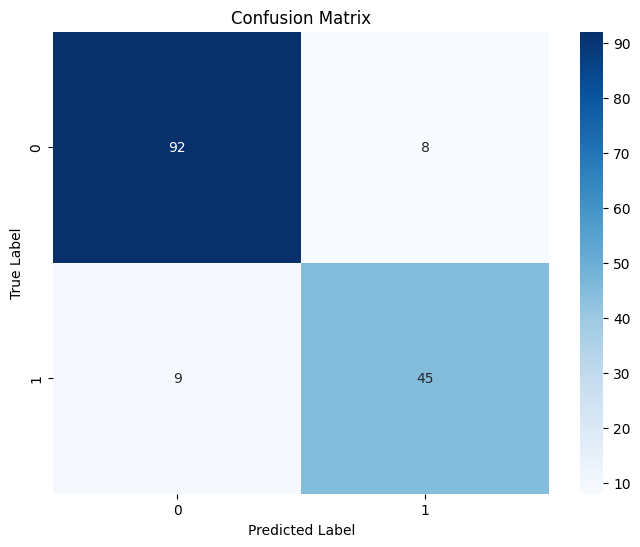

In [51]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Data Visualizations

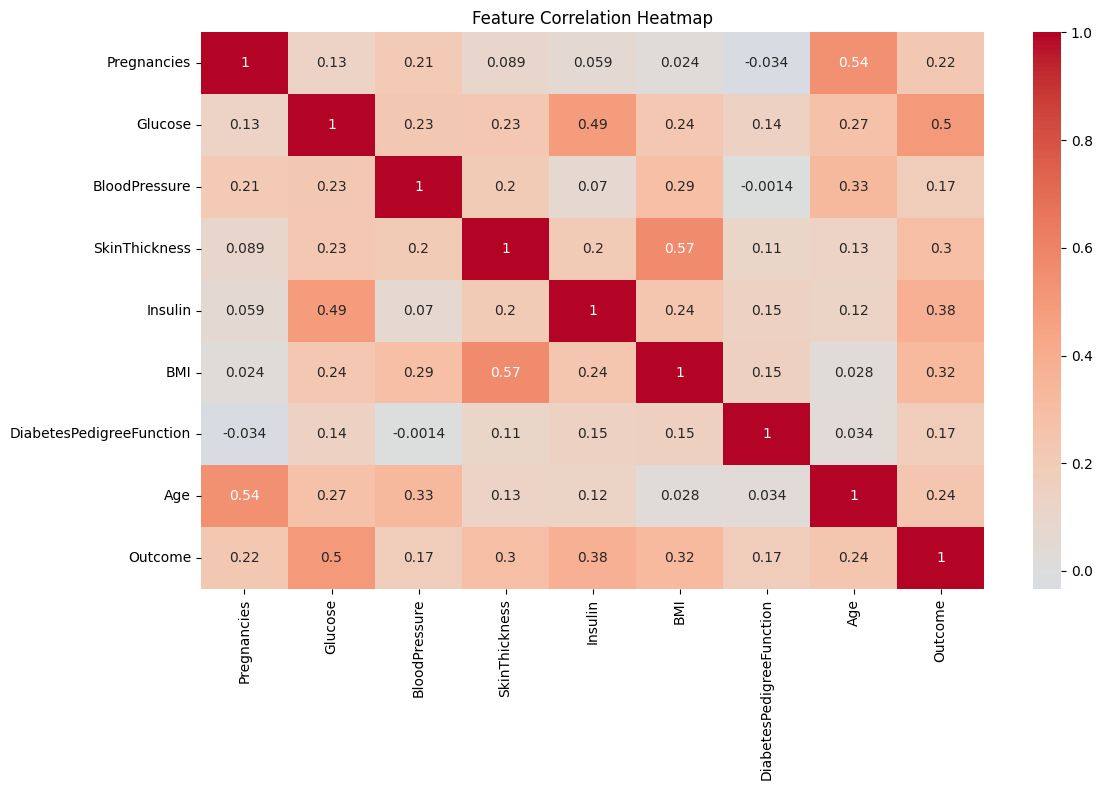

In [52]:
# 1. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_nan.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

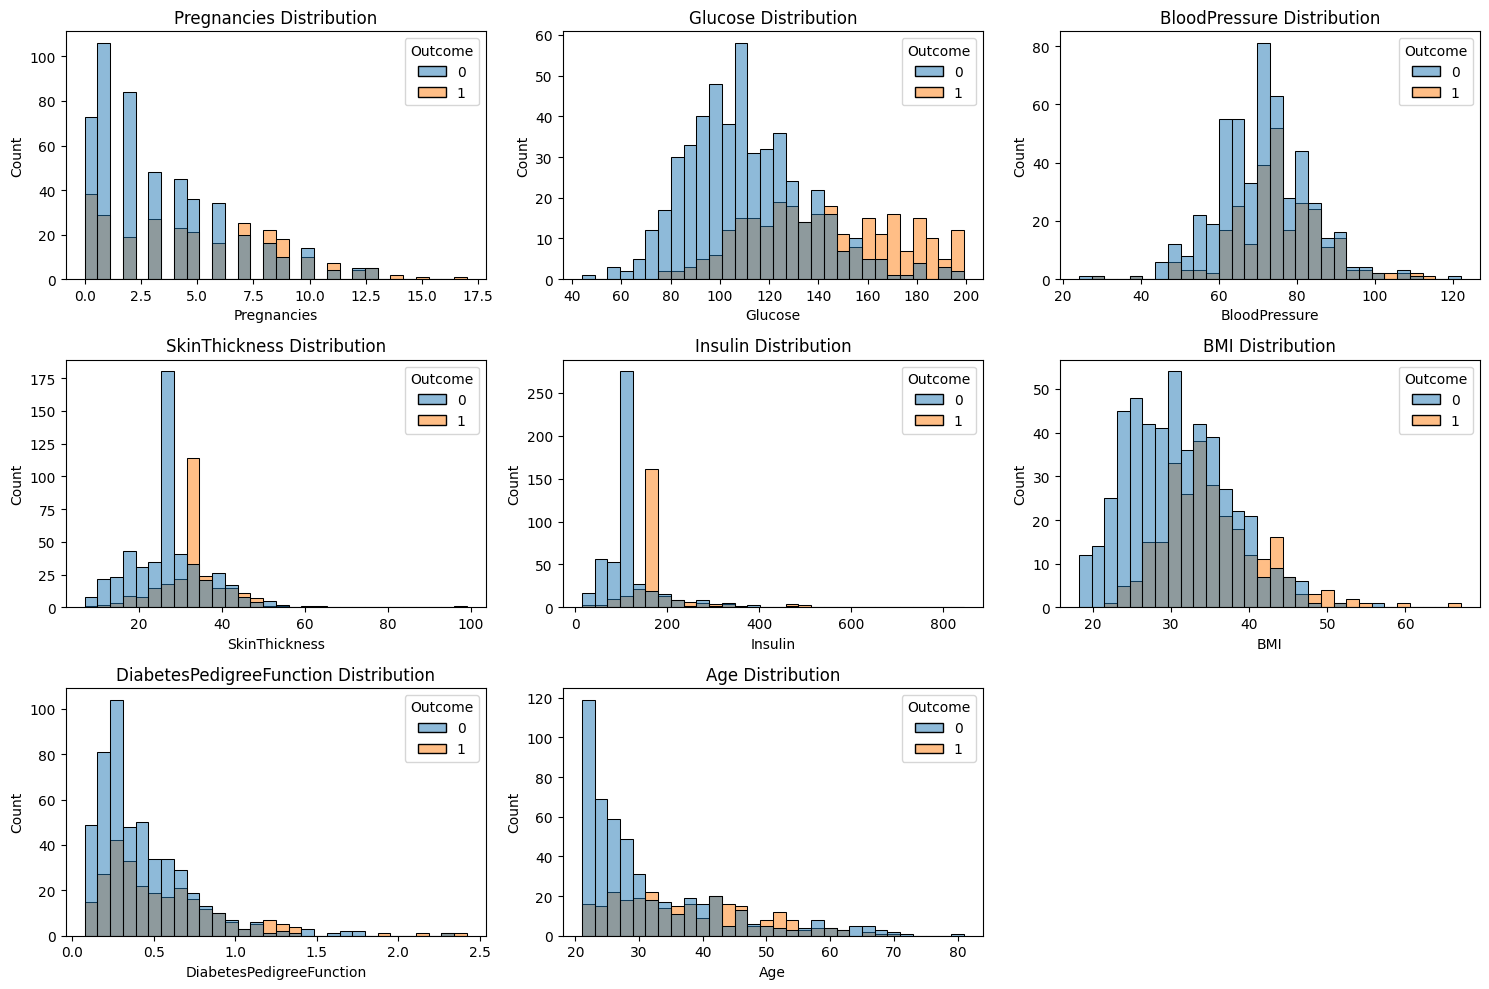

In [53]:
# 2. Distribution of Features
plt.figure(figsize=(15, 10))
for i, col in enumerate(df_nan.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_nan, x=col, hue='Outcome', bins=30)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()